In [1]:
from tracking_plot import plot_ratemap,plot_path
from neurochat.nc_data import NData
from neurochat.nc_spike import NSpike
from neurochat.nc_spatial import NSpatial
import neurochat.nc_plot as nc_plot
from neurochat.nc_lfp import NLfp
import matplotlib.pyplot as plt
import numpy as np
from pynwb import NWBHDF5IO
import matplotlib.pyplot as plt
import numpy as np
import math
import pynapple as nap
import numpy as np
from scipy import signal
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
import numpy as np
from sklearn.preprocessing import normalize
from spatial_maps.fields import separate_fields_by_laplace, separate_fields_by_dilation,find_peaks,separate_fields_by_laplace_of_gaussian,calculate_field_centers,distance_to_edge_function, remove_fields_by_area, map_pass_to_unit_circle,which_field,compute_crossings
from elephant.statistics import time_histogram, instantaneous_rate
from spatial_maps import maps
from spatial_maps.data import pos2speed
from scipy.ndimage import gaussian_filter

In [2]:
filepath = r"S:\Sachuriga/nwb/65588_2024-03-08_14-47-56_A_phy_k_manual.nwb"
data = nap.load_file(filepath)
data

65588_2024-03-08_14-47-56_A_phy_k_manual
┍━━━━━━━━━━━━━━━━━━┯━━━━━━━━━━┑
│ Keys             │ Type     │
┝━━━━━━━━━━━━━━━━━━┿━━━━━━━━━━┥
│ units            │ TsGroup  │
│ lfp_raw          │ TsdFrame │
│ lfp_car          │ TsdFrame │
│ XY               │ TsdFrame │
│ XY_snout         │ TsdFrame │
│ MD               │ TsdFrame │
│ HD               │ Tsd      │
│ BD               │ Tsd      │
│ ElectricalSeries │ TsdFrame │
┕━━━━━━━━━━━━━━━━━━┷━━━━━━━━━━┙

In [ ]:
a = np.load(r"S:\Sachuriga\Ephys_Recording\CR_CA1\65588\65588_2024-03-14_14-26-31_A\Record Node 101\experiment1\recording1\continuous\Acquisition_Board-100.Rhythm Data/sample_numbers.npy")
a

b = np.load(r"S:\Sachuriga\Ephys_Recording\CR_CA1\65588\65588_2024-03-14_14-26-31_A\Record Node 101\experiment1\recording1\continuous\Acquisition_Board-100.Rhythm Data/timestamps.npy")
print(b)


c = np.load(r"S:\Sachuriga\Ephys_Recording\CR_CA1\65588\65588_2024-03-14_14-26-31_A\Record Node 101\experiment1\recording1\events\Acquisition_Board-100.Rhythm Data\TTL/timestamps.npy")
print(np.diff(c))


In [3]:
scaler = MinMaxScaler()
# Fit and transform the data
pos = data['XY_snout']
t = data['XY_snout'].as_dataframe().index
scaler = MinMaxScaler(feature_range=(0, 1))
x = scaler.fit_transform(np.array(pos['x']).reshape(-1, 1)).flatten()
y = scaler.fit_transform(np.array(pos['y']).reshape(-1, 1)).flatten()

pos, mask,speed = pos2speed(t, x, y, filter_speed=True, min_speed = 0.05)



73503

1263
here
[1.0, 1.0]
bins zie[0.   0.05 0.1  0.15 0.2  0.25 0.3  0.35 0.4  0.45 0.5  0.55 0.6  0.65
 0.7  0.75 0.8  0.85 0.9  0.95 1.  ]


<Axes: title={'center': '6.47 Hz'}>

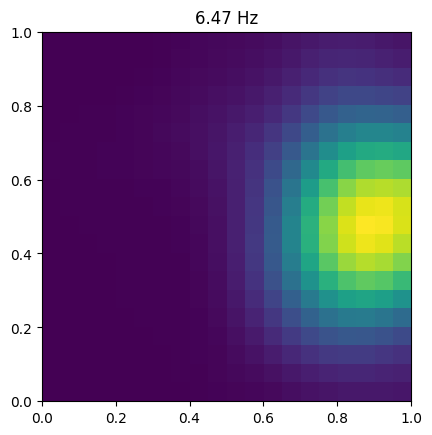

<Figure size 600x600 with 0 Axes>

In [ ]:
units = data['units']
spikes_time = np.array(units[11].as_series().index)
print(len(spikes_time))
t_ = np.append(t[1:], t[1:][-1] + np.median(np.diff(t[1:])))
spikes_in_bin, _ = np.histogram(spikes_time, t_)
spk = spikes_in_bin[mask]


speed_filtered_spikes(spikes_time,t,mask)

plot_ratemap(pos[:,1],pos[:,2],pos[:,0],spikes_time,box_size=[1.0, 1.0], bin_size=0.05,smoothing=0.1)

In [141]:
import spatial_maps.maps as mapp
maps = mapp.SpatialMap(box_size=[1.0, 1.0], bin_size=0.05,smoothing=0.1)
rate_map = maps.rate_map(x, y, t, spikes_time)
fields = separate_fields_by_laplace(rate_map, minimum_field_area=9)

fiesld_afremoval = remove_fields_by_area(fields, minimum_field_area=9)
bc = calculate_field_centers(rate_map, fiesld_afremoval, center_method='center_of_mass')
#print(bc)
x_c = bc[1][0]
y_c = bc[1][1]

#print(bc)
#print(y_c)
#print(fiesld_afremoval)
f = which_field(x,y,fiesld_afremoval,[1.0,1.0])
in_field = np.where(f==2)[0]
en,ex = compute_crossings(in_field)

xf = x[in_field]
yf = y[in_field]
tf = t[in_field]#
spk = spk[in_field]

indices = np.zeros(len(x))
indices[in_field]=1

en,ex = compute_crossings(indices)

[1.0, 1.0]
bins zie[0.   0.05 0.1  0.15 0.2  0.25 0.3  0.35 0.4  0.45 0.5  0.55 0.6  0.65
 0.7  0.75 0.8  0.85 0.9  0.95 1.  ]
[[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]]


C:\Users\sachur\AppData\Roaming\Python\Python311\site-packages\scipy\ndimage\_measurements.py:1541: RuntimeWarning: invalid value encountered in divide
  results = [sum(input * grids[dir].astype(float), labels, index) / normalizer


<Axes: >

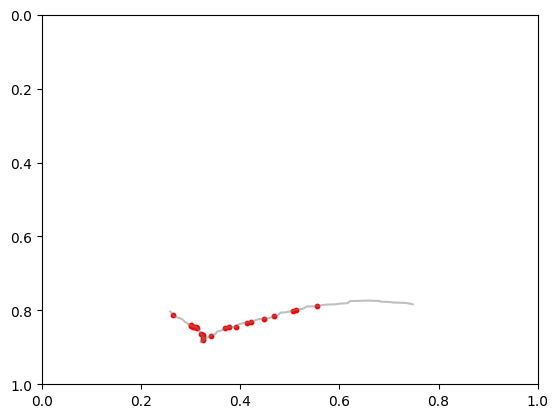

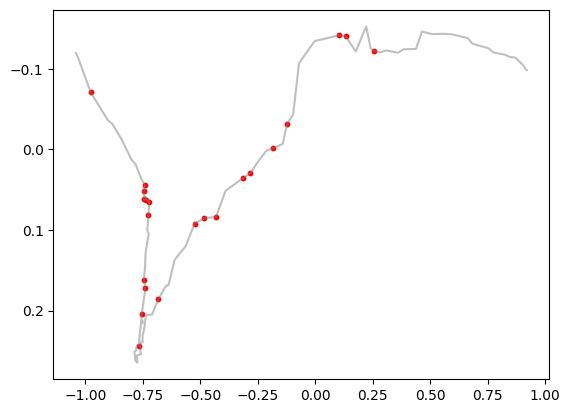

In [142]:
fig, ax = plt.subplots()
plt.xlim(0, 1)
plt.ylim(0, 1)
fig, ax1= plt.subplots()

slide_s=en[2]
slide_stop=ex[2]
plot_path(x[slide_s:slide_stop],y[slide_s:slide_stop],t[slide_s:slide_stop],box_size=1,spike_times = spikes_time, ax=ax)
r, theta, pdcd, pdmd = map_pass_to_unit_circle(x[slide_s:slide_stop],y[slide_s:slide_stop],t[slide_s:slide_stop], y_c/20,x_c/20, field=fiesld_afremoval, box_size=[1.0, 1.0])
x_r = r * np.cos(theta)
# #print(len(r),len(theta))
y_r = r * np.sin(theta)
#ax1.plot(pdcd,theta)
plot_path(x_r,y_r,t[slide_s:slide_stop],box_size=1,spike_times = spikes_time, ax=ax1)



In [143]:
print(len(x[slide_s:slide_stop]))
print(min(pdcd))

105
-0.8487393254367595


ValueError: Shape of array too small to calculate a numerical gradient, at least (edge_order + 1) elements are required.

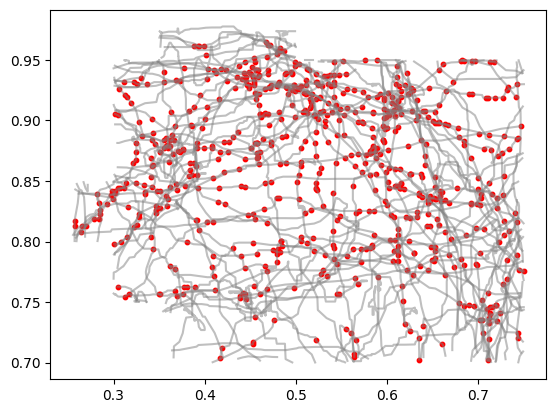

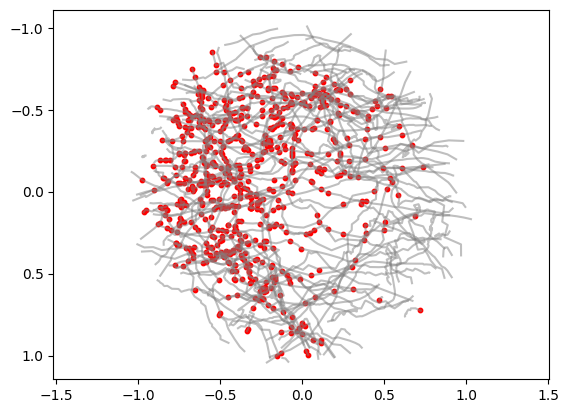

In [144]:
fig, ax = plt.subplots()
fig, ax1 = plt.subplots()
ax1.axis('equal')
for slide_s,slide_stop in zip(en,ex):
    plot_path(x[slide_s:slide_stop],y[slide_s:slide_stop],t[slide_s:slide_stop],box_size=1,spike_times = spikes_time, ax=ax)
    r, theta, pdcd, pdmd = map_pass_to_unit_circle(x[slide_s:slide_stop],y[slide_s:slide_stop],t[slide_s:slide_stop], y_c/20, x_c/20, field=fiesld_afremoval, box_size=[1.0, 1.0])

    x_r = r * np.cos(theta)
    # #print(len(r),len(theta))
    y_r = r * np.sin(theta)
    plot_path(x_r,y_r,t[slide_s:slide_stop],box_size=1,spike_times = spikes_time, ax=ax1)

    #ax1.axis('equal')
    #plt.bar(tf[slide_s:slide_stop],xf[slide_s:slide_stop])

    # xr = xf[slide_s:slide_stop]
    # yr = yf[slide_s:slide_stop]
    # tr = tf[slide_s:slide_stop]

    # # r, theta, pdcd, pdmd = map_pass_to_unit_circle(xr, yr, tr, x_c/100, y_c/100, field=fiesld_afremoval, box_size=[1.0, 1.0])

    # # plt.figure()
    # # plt.plot(tr,pdcd)

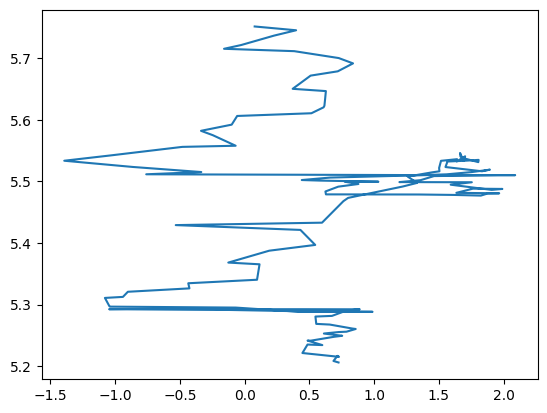

In [111]:
plt.plot(pdcd,theta)

plt.show()



In [105]:
theta

array([4.25520859, 4.25903326, 4.26618841, 4.268088  , 4.27311429,
       4.27841266, 4.28039236, 4.28326445, 4.28436997, 4.28687023,
       4.29159204, 4.2933221 , 4.29566936, 4.29600829, 4.30186609,
       4.3071316 , 4.31104038, 4.31205401, 4.31829947, 4.31875932,
       4.32428364, 4.32606287, 4.32613629, 4.32613629, 4.32593683,
       4.3255036 , 4.32463534, 4.32516026, 4.32516026, 4.32822237,
       4.32724774, 4.32660947, 4.31849002, 4.31921393, 4.31643002,
       4.31744474, 4.31597522, 4.31657469, 4.32536575, 4.32477707,
       4.32937748, 4.33380364, 4.34535221, 4.34586046, 4.34589391,
       4.36377328, 4.36661008, 4.37700333, 4.39099745, 4.39769734,
       4.40858193, 4.41365863, 4.43099749, 4.44527165, 4.45450879,
       4.4572701 , 4.4745278 , 4.48005626, 4.49105253, 4.49382137,
       4.50260085, 4.50584228, 4.5121    , 4.51387605, 4.51466561,
       4.51943321, 4.52205944, 4.52777918, 4.53286968, 4.53424881,
       4.53510275, 4.5346194 , 4.53389678, 4.5334183 , 4.53335

In [ ]:
plt.bar(r)

In [ ]:
mask = (r > -1) & (r < 1)

# Use the mask to filter x, y, and pdcd
x_filtered = x[mask]
y_filtered = y[mask]
pdcd_filtered = r[mask]
theta_filtered = theta[mask]


# Now plot using the filtered data
plt.scatter(x_filtered, y_filtered, c=pdcd_filtered, cmap='hot', alpha=0.7)
plt.colorbar(label='Intensity')
plt.xlim(0, 1)
plt.ylim(0, 1)

plt.show()

In [ ]:
def map_pass_to_unit_circle(x, y, t, x_c, y_c, field=None, box_size=None, dist_func=None):
    """Uses three vectors {v,p,q} to map the passes to the unit circle. v
    is the average velocity vector of the pass, p is the vector from the
    position (x,y) to the center of the field and q is the vector from the
    center to the edge through (x,y). See [1].

    Parameters:
    -----------
        :x, y, t: np arrays
            should contain x,y and t data in numpy arrays
        :x_c , y_c: floats
            bump center
        :field: np 2d array (optional)
            bins indicating location of field.
        :dist_func: function (optional)
            dist_func(angle) = distance to bump edge from center
            default is distance_to_edge_function with linear interpolation
        :return_vecs(optional): bool, default False

    See also:
    ---------
    distance_to_edge_function

    Returns:
    --------
        r : array of distance to origin on unit circle
        theta : array of angles to axis defined by mean velocity vector
        pdcd : array of distance to peak projected onto the current direction
        pdmd : array of distance to peak projected onto the mean direction

    References:
    -----------
        [1]: A. Jeewajee et. al., Theta phase precession of grid and
        placecell firing in open environment
    """
    if dist_func is None:
        assert field is not None and box_size is not None, (
            'either provide "dist_func" or "field" and "box_size"')
        dist_func= distance_to_edge_function(
            x_c, y_c, field, box_size, interpolation='linear')
    pos = np.array((x, y))

    # vector from pos to center p
    p_vec = ((x_c, y_c) - pos.T).T

    # angle between x-axis and negative vector p
    angle = (np.arctan2(p_vec[1], p_vec[0]) + np.pi) % (2 * np.pi)
    # distance from center to edge at each angle
    q = dist_func(angle)
    # distance from center to pos
    p = np.linalg.norm(p_vec, axis=0)
    # r-coordinate on unit circle
    r = p / q

    dpos = np.gradient(pos, axis=1)
    dt = np.gradient(t)
    velocity = np.divide(dpos, dt)

    # mean velocity vector v
    mean_velocity = np.average(velocity, axis=1)
    # angle on unit circle, run is rotated such that mean velocity vector
    # is toward positive x
    theta = (angle - np.arctan2(mean_velocity[1], mean_velocity[0])) % (2 * np.pi)

    w_pdcd = (angle - np.arctan2(velocity[1], velocity[0]))
    pdcd = r * np.cos(w_pdcd)

    w_pdmd = (angle - np.arctan2(mean_velocity[1], mean_velocity[0]))
    pdmd = r * np.cos(w_pdmd)
    return r, theta, pdcd, pdmd


In [ ]:
min(pdcd)